# **AEGIS LENS EXPLORATORY DATA ANALYSIS**

## i. Import Libraries

In this step, we will import the libraries needed for Exploratory Data Analysis. The libraries used may be updated depending on what we explore later.

In [1]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2
from collections import defaultdict

## ii. Split Data Train and Val

In this step, we will split the dataset into two parts: training and validation. We divide the dataset into 80% for training and 20% for validation.

In [ ]:
#Split Train and Val
base_dir = "Dataset"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

output_dirs = {
    "train": 0.8,
    "val": 0.2,
}

for split in output_dirs:
    os.makedirs(os.path.join(base_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, "labels"), exist_ok=True)

image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

total = len(image_files)
start = 0
for split, ratio in output_dirs.items():
    count = int(total * ratio)
    selected_files = image_files[start:start + count]
    for file in selected_files:
        src_img = os.path.join(images_dir, file)
        dst_img = os.path.join(base_dir, split, "images", file)
        shutil.copy(src_img, dst_img)

        label_file = file.rsplit('.', 1)[0] + ".txt"
        src_label = os.path.join(labels_dir, label_file)
        dst_label = os.path.join(base_dir, split, "labels", label_file)
        if os.path.exists(src_label):
            shutil.copy(src_label, dst_label)

    start += count

## iii. Loading Data for EDA

At this stage, we will load the training dataset that has been split from the main dataset. This training dataset is what we will analyze, with the expectation that the analysis results will help us build the model.

In [2]:
#Dataset Train path
images_dir = 'Dataset/train/images'
labels_dir = 'Dataset/train/labels'

In [3]:
#See all Label/Class
classes_path = 'Dataset/classes.txt'

with open(classes_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print("Class Names:")
for idx, class_name in enumerate(classes):
    print(f"{idx}: {class_name}")

Class Names:
0: Bus
1: Car
2: LicensePlate
3: Motorcycle
4: Truck


Insight : 

There are 5 Classes/Labels:

0 for Bus
1 for Car
2 for License Plate
3 for Motorcycle
4 for Truck

These classes are types of vehicles we classify, along with license plates whose numbers will be detected.

In [4]:
#Loading data train
records = []

image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    image = plt.imread(image_path)
    h, w = image.shape[:2]

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            records.append({
                'image': image_file,
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height,
                'area': width * height,
                'aspect_ratio': width / height if height != 0 else 0
            })

df = pd.DataFrame(records)

## iv. EDA

In this section, we will perform several analyses on the dataset. Here are some questions that need to be analyzed:

1. What is the object distribution across all classes?
2. How many objects are typically found in each image?
3. What is the size distribution of bounding boxes for each class?
4. What is the distribution of bounding box aspect ratios (width to height)?
5. What do example images with bounding boxes look like?
6. What patterns can we observe from the heatmap of bounding box centroids?

### 1. Distribution of Objects per Class

This section analyzes how objects are distributed across the five classes in the dataset:  
- **Class 0**: Bus  
- **Class 1**: Car  
- **Class 2**: License Plate  
- **Class 3**: Motorcycle  
- **Class 4**: Truck

By understanding the distribution, we can identify class imbalance issues that may affect model performance.

C:\Users\maruf\AppData\Local\Temp\ipykernel_3216\468261256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='class_id', data=df, palette='Set2')


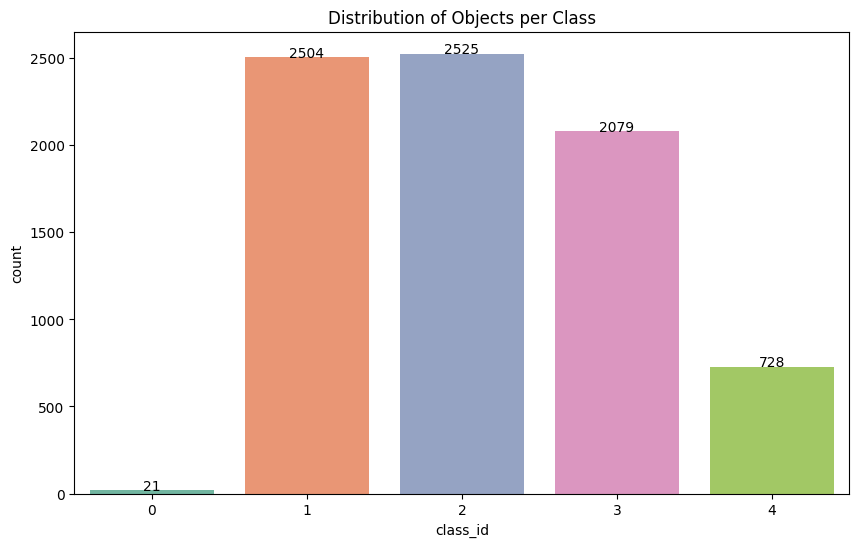

In [6]:
# Make plot for Distribution of Object per Class
plt.figure(figsize=(10,6))
ax = sns.countplot(x='class_id', data=df, palette='Set2')
plt.title('Distribution of Objects per Class')

# Show value in every bar
for p in ax.patches:
    height = p.get_height()  
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, 
            int(height), 
            ha="center") 

plt.show()

**Insight: Class Distribution**

- The bar chart above illustrates the **class distribution in the training dataset**.  
- **Class 0 (Bus)** has **very few samples** compared to the other four classes, indicating a **data imbalance**.  
- **Class 2 (Motorcycle)** has the **highest number of samples**, followed by Class 1 (Car) and Class 3 (License Plate), with a difference of about 300 samples between Class 2 and 3.  
- **Class 4 (Truck)** also has **relatively fewer samples**, though still significantly more than Class 0 (Bus).  
- Overall, this suggests that **the data collection environment is dominated by cars and motorcycles**.  
- The number of **License Plate labels** is relatively low compared to the total number of vehicle objects, meaning **not all vehicles had readable license plates**.  
- To address the class imbalance—especially for **Class 0 (Bus)** and **Class 4 (Truck)**—**additional sampling is recommended**. For buses, this can be done in areas near **bus terminals**, and for trucks, in **industrial zones or logistic warehouses**.

___________________________________________________________________________________________________________________________________________________________________________________________
Based on the insight that Class 0 (Bus) is underrepresented, we will now look at example images containing objects from this class.

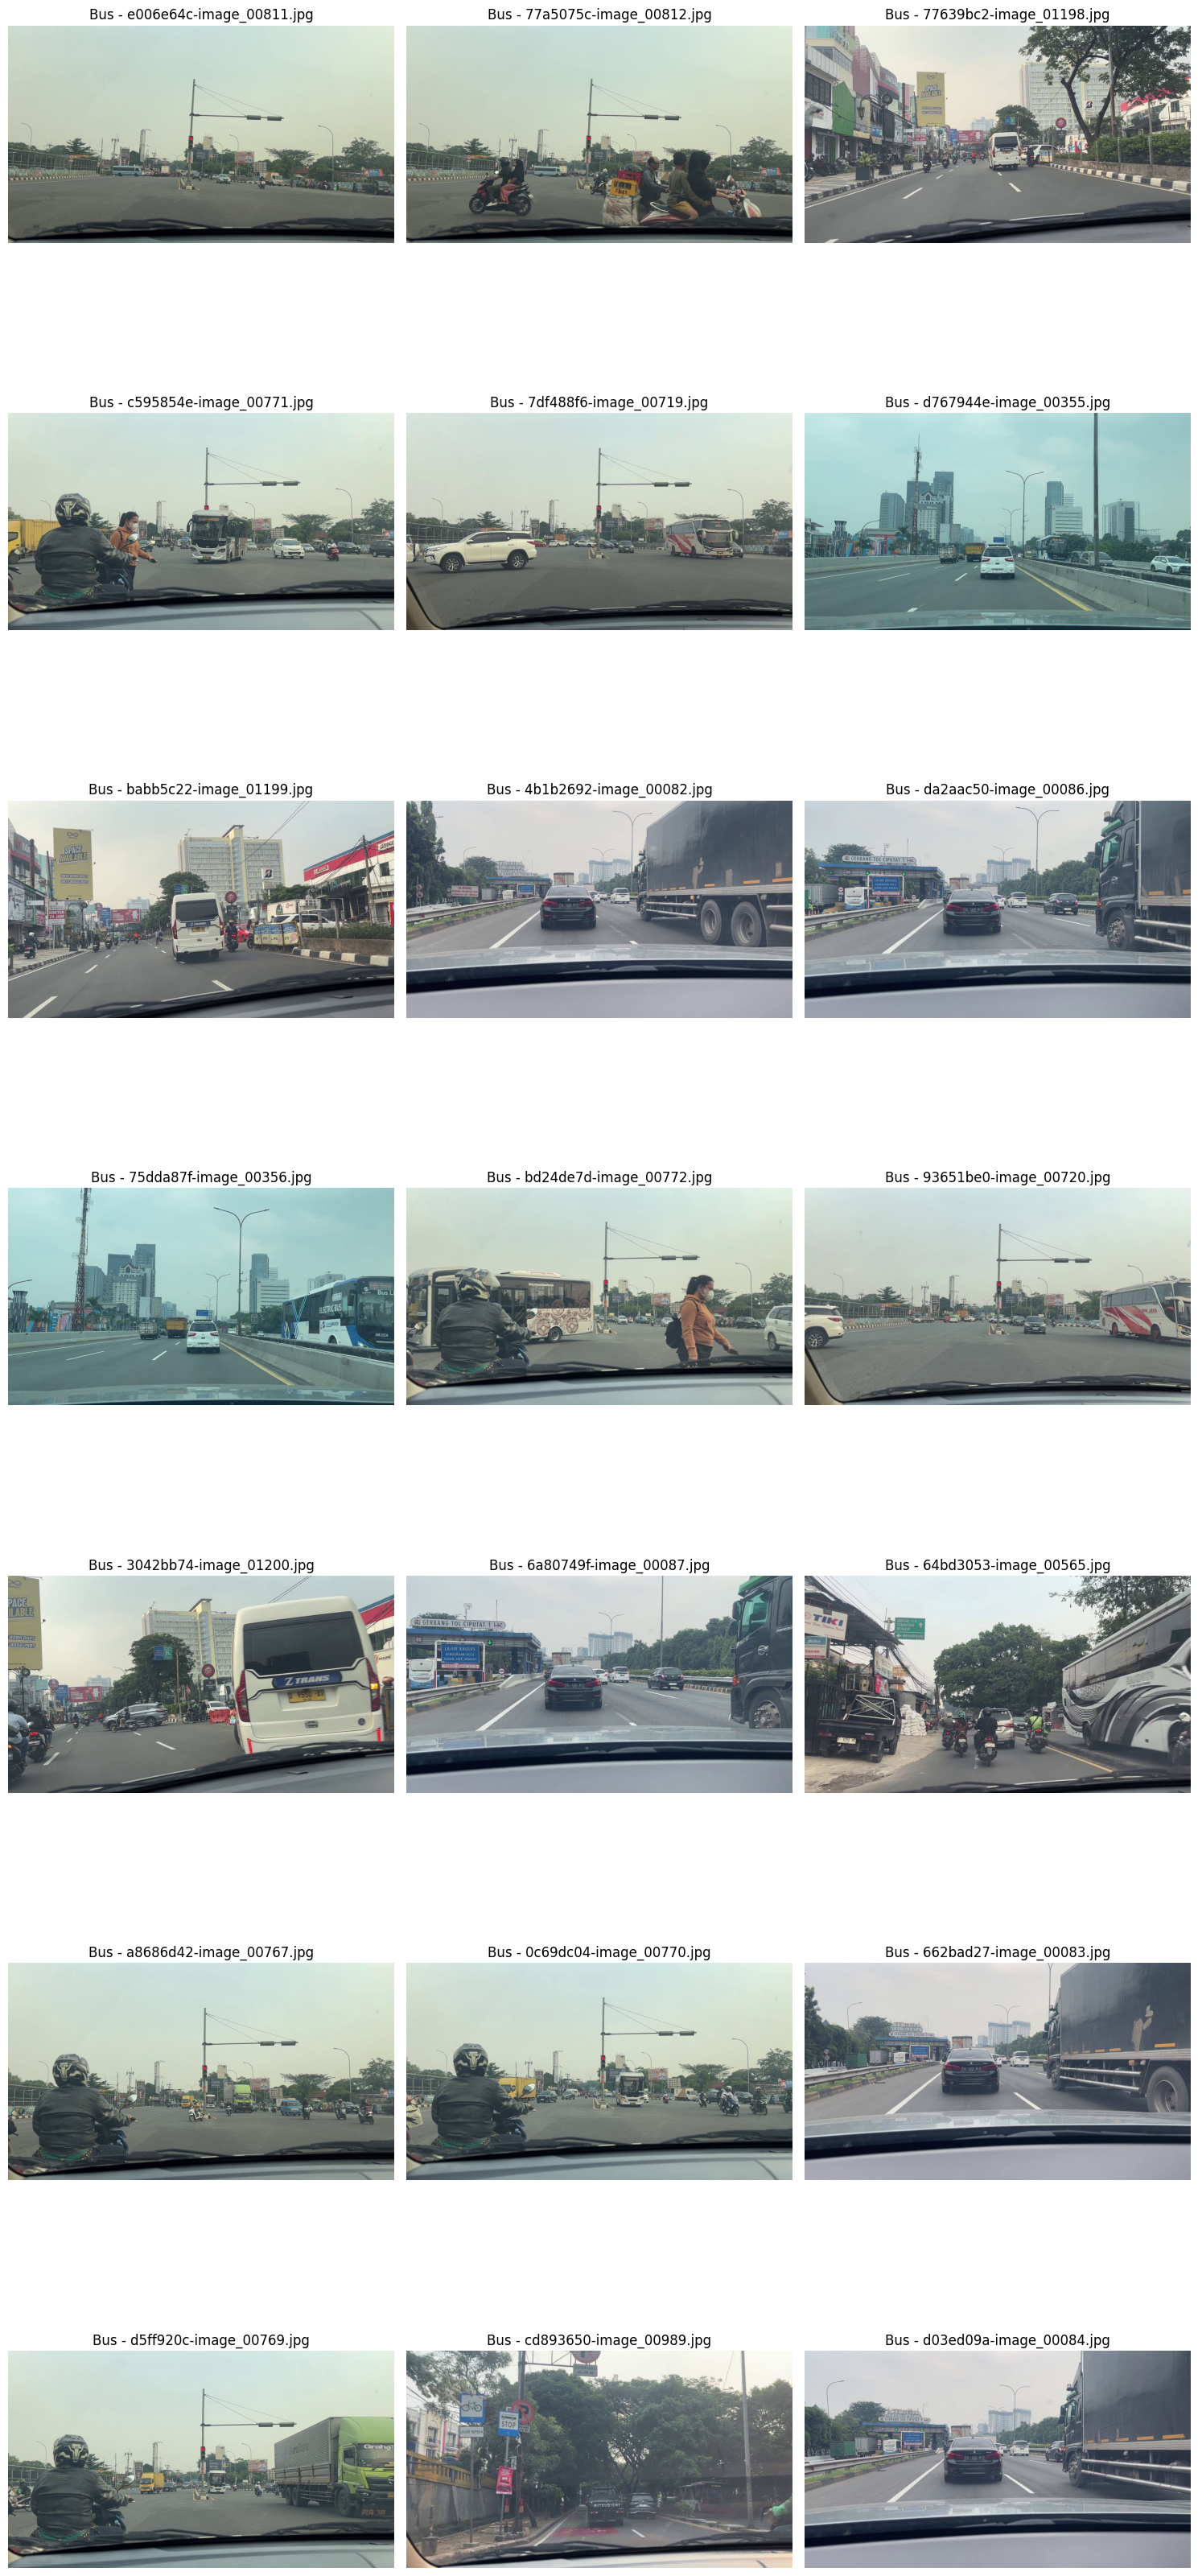

In [ ]:
max_images = 30
cols = 3

images_to_show = []

for label_file in os.listdir(labels_dir):
    if not label_file.endswith('.txt'): continue
    label_path = os.path.join(labels_dir, label_file)

    with open(label_path, 'r') as f: lines = f.readlines()
    if not any(line.startswith('0 ') for line in lines): continue

    image_file = label_file.replace('.txt', '.jpg')
    image_path = os.path.join(images_dir, image_file)
    if not os.path.exists(image_path): continue

    images_to_show.append(image_path)

    if len(images_to_show) >= max_images:
        break

# Calculate the number of rows based on the number of images to be displayed
rows = len(images_to_show) // cols + int(len(images_to_show) % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, image_path in enumerate(images_to_show):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Bus - {os.path.basename(image_path)}")
    axes[i].axis('off')

# Turn off all unused axes
for j in range(len(images_to_show), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### 2. Distribution of the Number of Objects per Image

This section explores how many labeled objects typically appear in each image.

Understanding this distribution helps us:  
- Identify whether the dataset is suited for single or multi-object detection.  
- Understand the complexity of each image in terms of object density.  
- Determine how well the model needs to handle crowded versus sparse scenes.

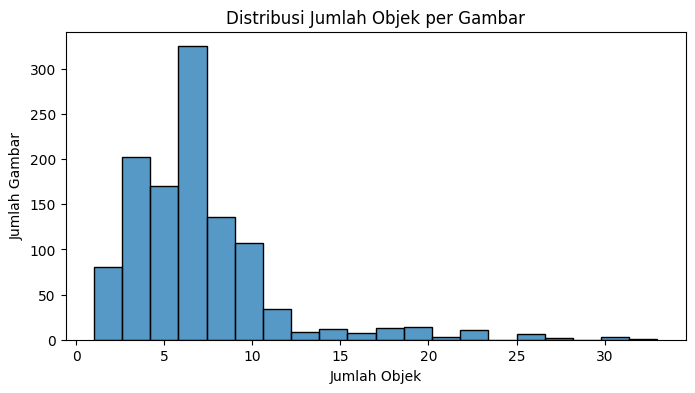

In [ ]:
# Distribution of the Number of Objects per Image
obj_per_image = df.groupby('image').size()
plt.figure(figsize=(8,4))
sns.histplot(obj_per_image, bins=20, kde=False)
plt.title('Distribution of the Number of Objects per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')
plt.show()

**Insight: Number of Labeled Objects per Image**

- The chart shows the **distribution of labeled objects per image**.  
- Most images **contain more than one object**, with the majority having **between 4 to 8 objects**.  
- There are also images with **15–20 objects**, and even some with up to **30 objects**, although these are fewer than 10 images in total.  
- The **distribution is uneven**, with a dominance of images containing a **moderate number of objects (around 4–5)**. This could affect the model’s performance, as it may become more optimized for detecting objects within that range.


___________________________________________________________________________________________________________________________________________________________________________________________
After analyzing the object count per image, we also explore the following aspects:  
1. Average number of objects per image  
2. Percentage of images with only 1 object  
3. Percentage of images containing both vehicles and license plates

In [7]:
# Count the number of objects per image and the types of classes present
image_obj_count = defaultdict(int)
image_classes = defaultdict(set)

for _, row in df.iterrows():
    img = row['image']
    cls = row['class_id']
    image_obj_count[img] += 1
    image_classes[img].add(cls)

# Average number of objects per image
total_objects = sum(image_obj_count.values())
total_images = len(image_obj_count)
avg_objects_per_image = total_objects / total_images

# Percentage of images with only 1 object
single_obj_images = sum(1 for count in image_obj_count.values() if count == 1)
pct_single_obj_images = (single_obj_images / total_images) * 100

# Percentage of images with both vehicle(s) and license plate
vehicle_classes = {0, 1, 3, 4}
plate_class = 2

combination_images = 0
for img, classes in image_classes.items():
    has_vehicle = any(c in vehicle_classes for c in classes)
    has_plate = plate_class in classes
    if has_vehicle and has_plate:
        combination_images += 1

pct_combination = (combination_images / total_images) * 100

print(f"Total number of images                     : {total_images}")
print(f"Average number of objects per image        : {avg_objects_per_image:.2f}")
print(f"Images with only 1 object                  : {single_obj_images} ({pct_single_obj_images:.2f}%)")
print(f"Images with both vehicle(s) and license plate : {combination_images} ({pct_combination:.2f}%)")

Total number of images                     : 1137
Average number of objects per image        : 6.91
Images with only 1 object                  : 25 (2.20%)
Images with both vehicle(s) and license plate : 1005 (88.39%)


**Insight: Object Statistics per Image**

1. The **average number of objects per image** is **6.91**, indicating that most images contain multiple objects.  
2. About **2.2% of images** contain **only one object**, confirming that this dataset is suitable for multi-object detection models.  
3. Around **1005 images (88.39%)** contain a **combination of vehicle and license plate**, meaning license plates are typically present alongside the vehicle. This co-occurrence can help the model better learn the positioning of license plates.

### 3. Bounding Box Size Distribution Pattern by Class

In this section, we examine how bounding box sizes vary across different object classes.

Key objectives:  
- Understand whether certain classes tend to have consistently larger or smaller bounding boxes.  
- Identify challenges related to small object detection (e.g. License Plates).  
- Adjust model strategies accordingly based on object scale differences.

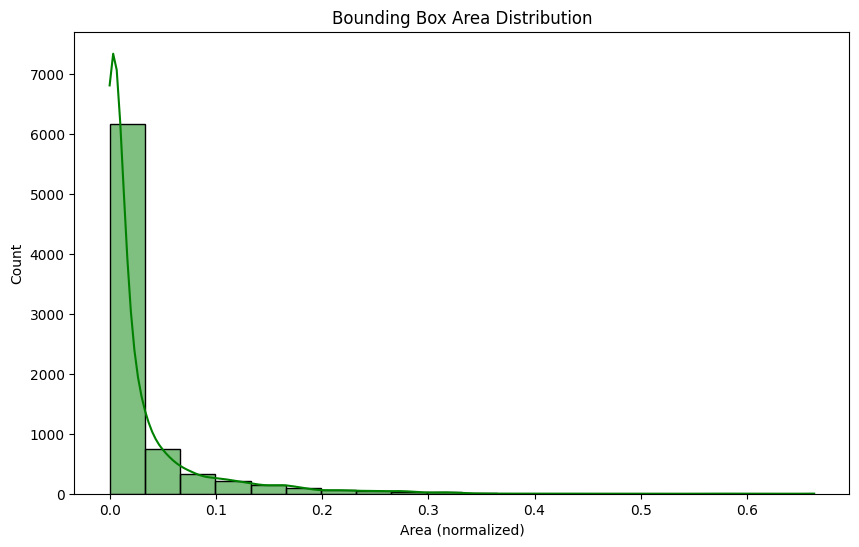

In [8]:
# Bounding Box Size (Area) Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['area'], bins=20, color='green', stat='count', kde=True)
plt.title('Bounding Box Area Distribution')
plt.xlabel('Area (normalized)')
plt.ylabel('Count')
plt.show()

**Insight: Bounding Box Size Distribution**

- The chart illustrates the **distribution of bounding box sizes** in the dataset.  
- Most bounding boxes are **relatively small**, likely dominated by **license plates** or **objects far from the camera**.  
- The **small size of license plate bounding boxes** could present a **challenge for the OCR model**, especially for reading license numbers and expiry dates.  
- There are also **large bounding boxes**, likely belonging to **buses, trucks, or cars close to the camera**.  
- Since small bounding boxes are the most common, the **model must be optimized to detect small objects effectively**.  
- Conversely, due to the lower occurrence of large bounding boxes, the **model should still be capable of recognizing large-sized objects** when present.


### 4. Bounding Box Aspect Ratio Distribution (Width-to-Height)

This section analyzes the distribution of bounding box aspect ratios, calculated as **width divided by height**.

Purpose of this analysis:  
- Identify shape patterns specific to each class (e.g., horizontal vs. vertical rectangles).  
- Understand the spatial characteristics of objects like **License Plates** (typically wide) and **Motorcycles** (typically tall).  
- Help inform model design to better handle varying object shapes.

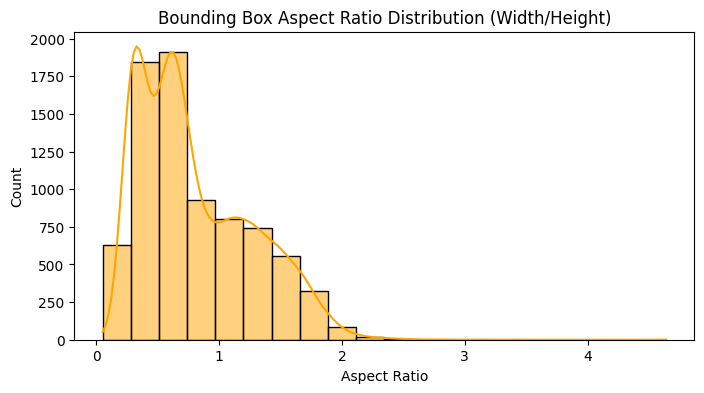

In [9]:
# Bounding Box Aspect Ratio Distribution
plt.figure(figsize=(8,4))
sns.histplot(df['aspect_ratio'], bins=20, kde=True, color='orange')
plt.title('Bounding Box Aspect Ratio Distribution (Width/Height)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')
plt.show()

**Insight : Bounding Box Aspect Ratio Distribution**

- The chart above shows the **distribution of bounding box aspect ratios (width/height)**.
- **Smaller ratios** (less than 1) likely represent **License Plates**.
- **Larger ratios** (greater than 1) may correspond to **Buses, Cars, Trucks**, or objects that appear closer to the camera.
- **License plates** generally have a **wider width (x) than height (y)**, making them **horizontal rectangles**.
- **Motorcycles**, on the other hand, typically have a **greater height (y) than width (x)**, resulting in **vertical rectangle shapes**.
- Therefore, license plates are usually **horizontally shaped**, while motorcycles tend to be **vertically shaped**.

### 5. Sample Visualizations of Labeled Images

This section presents sample images from the dataset with their corresponding bounding boxes and class labels for visual inspection.

The purpose of this visualization is to:  
- Verify the accuracy and consistency of labeling.  
- Observe variations in object size, shape, and positioning.  
- Understand real-world image conditions such as lighting, occlusion, and viewing angles.

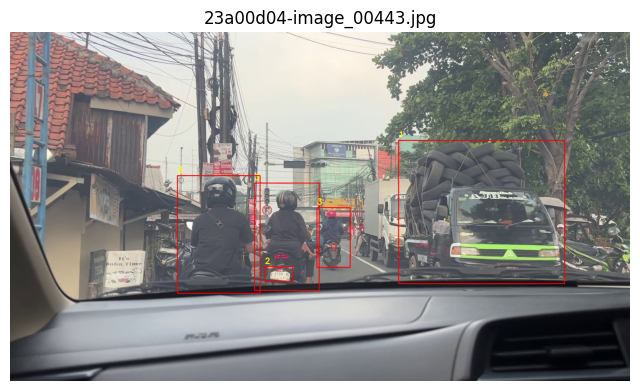

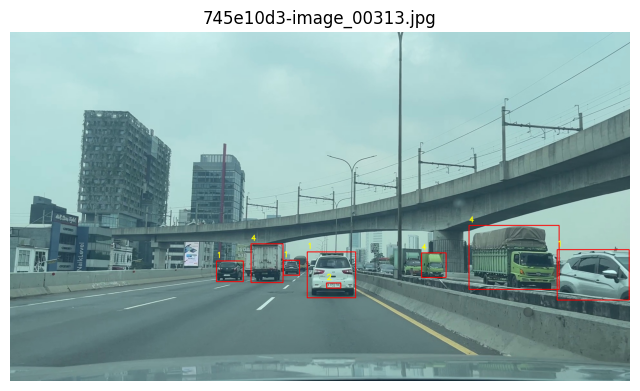

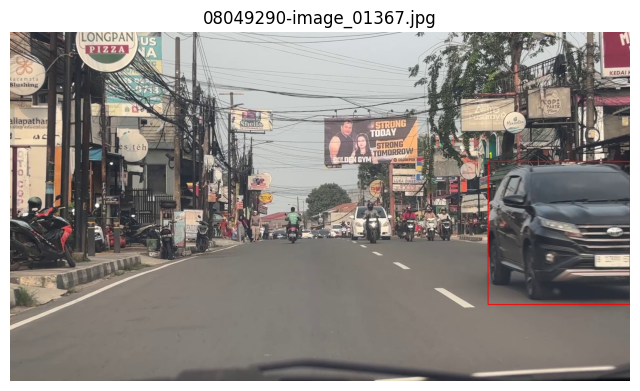

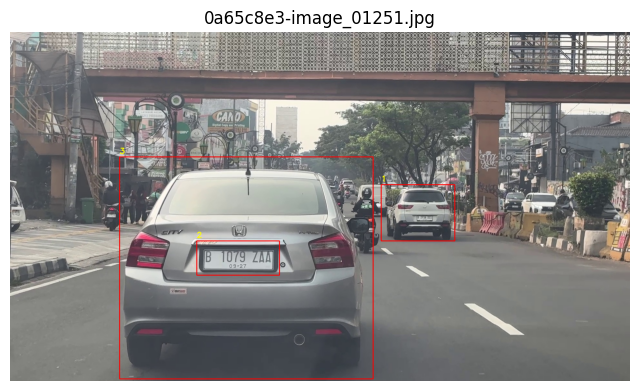

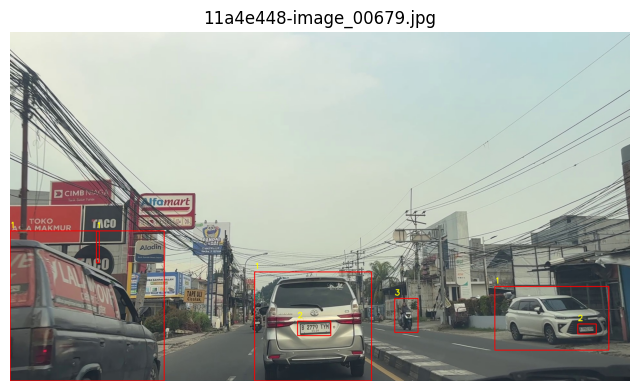

In [10]:
# Visualize 5 random images with bounding boxes
sample_images = df['image'].unique()
sample_images = np.random.choice(sample_images, size=min(5, len(sample_images)), replace=False)

for image_file in sample_images:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = df[df['image'] == image_file]
    for _, row in boxes.iterrows():
        xmin = int((row['x_center'] - row['width']/2) * w)
        ymin = int((row['y_center'] - row['height']/2) * h)
        xmax = int((row['x_center'] + row['width']/2) * w)
        ymax = int((row['y_center'] + row['height']/2) * h)
        class_id = row['class_id']

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, str(class_id), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')
    plt.show()

**Insight : Visualizations of Labeled Images**

- The images above are **examples of labeled visualizations** from the dataset.
- **Most objects are captured from the rear**, with only **a few labeled from the front or side**.
- There is a **clear variation in bounding box sizes** across classes. For example, **cars** tend to have **more symmetrical width and height**, compared to motorcycles.
- The **label shape for motorcycles** appears **taller and narrower** than other classes.
- **Trucks** have bounding boxes that are **significantly larger** compared to other objects.
- The **License Plate** is the **smallest object** among all classes.
- Given these **distinct shape differences**, the model should be able to **learn and distinguish between classes effectively**.


### 6. Distribution of Bounding Box Centroid Positions

This section visualizes the spatial distribution of bounding box centroids to identify patterns in object placement within the images.  

Key insights we aim to uncover:  
- Identify whether objects are mostly centered or scattered across the frame.  
- Detect any positional bias that may affect model learning.  
- Understand common placements of certain object types, such as License Plates, which often appear in the lower-middle region of the image.

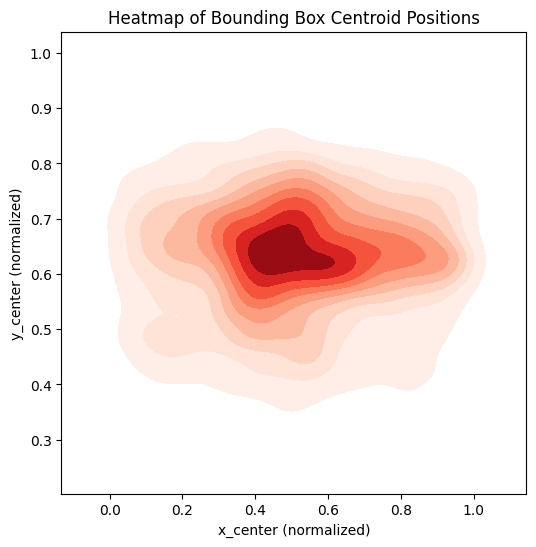

In [11]:
# Heatmap of Bounding Box Centroid Positions
plt.figure(figsize=(6,6))
sns.kdeplot(x=df['x_center'], y=df['y_center'], fill=True, cmap='Reds')
plt.title('Heatmap of Bounding Box Centroid Positions')
plt.xlabel('x_center (normalized)')
plt.ylabel('y_center (normalized)')
plt.show()

**Insight : Heatmap of Bounding Box Centroid Positions**

- The heatmap above shows the **distribution of bounding box centroid positions**.
- From the heatmap, we can conclude that **most objects are centered around (0.4–0.6, 0.6–0.7)**. This is indicated by the **darker regions** in that area.
- The **centroids tend to cluster around the center of the image**, suggesting that **most objects appear near the middle** of the frame.
- It is also likely that **license plates are located around the y = 0.6 region**, which corresponds to the **lower-middle part of the image**.


## EDA Summary
This section summarizes key insights gathered from the Exploratory Data Analysis (EDA) phase.

- The dataset contains 5 classes, with noticeable class imbalance in the **Bus** and **Truck** categories.  
- Most images contain **more than one object**, often featuring a combination of **vehicles and license plates**.  
- Bounding box sizes and aspect ratios vary significantly — from **small, horizontally shaped license plates** to **taller, vertically shaped motorcycles**.  
- The centroids of bounding boxes are **concentrated near the center of the image**, indicating that most objects appear in central regions.
